# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [41]:
import condensate_speckle
from condensate_speckle.data_io import get_example_data_file_path, load_data
from condensate_speckle.inference.model import set_model

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where Y is the intensity value, $\phi_i$ is parameters that depends on $\tau$, $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

To generate data, variable we need are the distibution of $e_t$, including their mean $c$ and standard deviation $\sigma_e$, and $\tau$. Here, $e_t$ is considered as Gaussian distribution. $\tau$ is the value we decide on. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

The overall intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import csv

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/wenyun/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [38]:
X = load_data('simulated_data.csv',data_dir='condensate_speckle/example_data').to_numpy()

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/simulated_data.csv


In [39]:
X

array([[0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        4.99700000e+03, 4.99800000e+03, 4.99900000e+03],
       [7.33414121e+01, 6.28812338e+01, 5.28239350e+01, ...,
        7.78543432e+01, 8.49557896e+01, 9.11642602e+01]])

In [33]:
print('the mean of simulated data is {}'.format(np.average(data1[1])))
print('the std of simulated data is {}'.format(np.std(data1[1])))

the mean of simulated data is 83.33651926064175
the std of simulated data is 20.54291754091548


In [12]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Fitting simulated data with pymc3 AR(1) model

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [43]:
quantization = 255
ar1_model=set_model(X,quantization)

In [44]:
estimate = pm.find_MAP(model = ar1_model)

In [45]:
estimate

{'decay_time_interval__': array(-1.35561769),
 'precision_interval__': array(-4.30015661),
 'center_interval__': array(-0.72272443),
 'camera': array(5.),
 'decay_time': array(10.24767332),
 'precision': array(0.01338485),
 'center': array(83.33229843)}

In [47]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_16029/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 17600
Interrupted at 17,599 [8%]: Average Loss = 37,992
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [camera, center, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


/Users/wenyun/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:213: UserWarning: A valid var_name should be provided, found {'noise_mean', 'noise_std'} expected from {'precision', 'center', 'camera', 'decay_time'}
  warnings.warn(


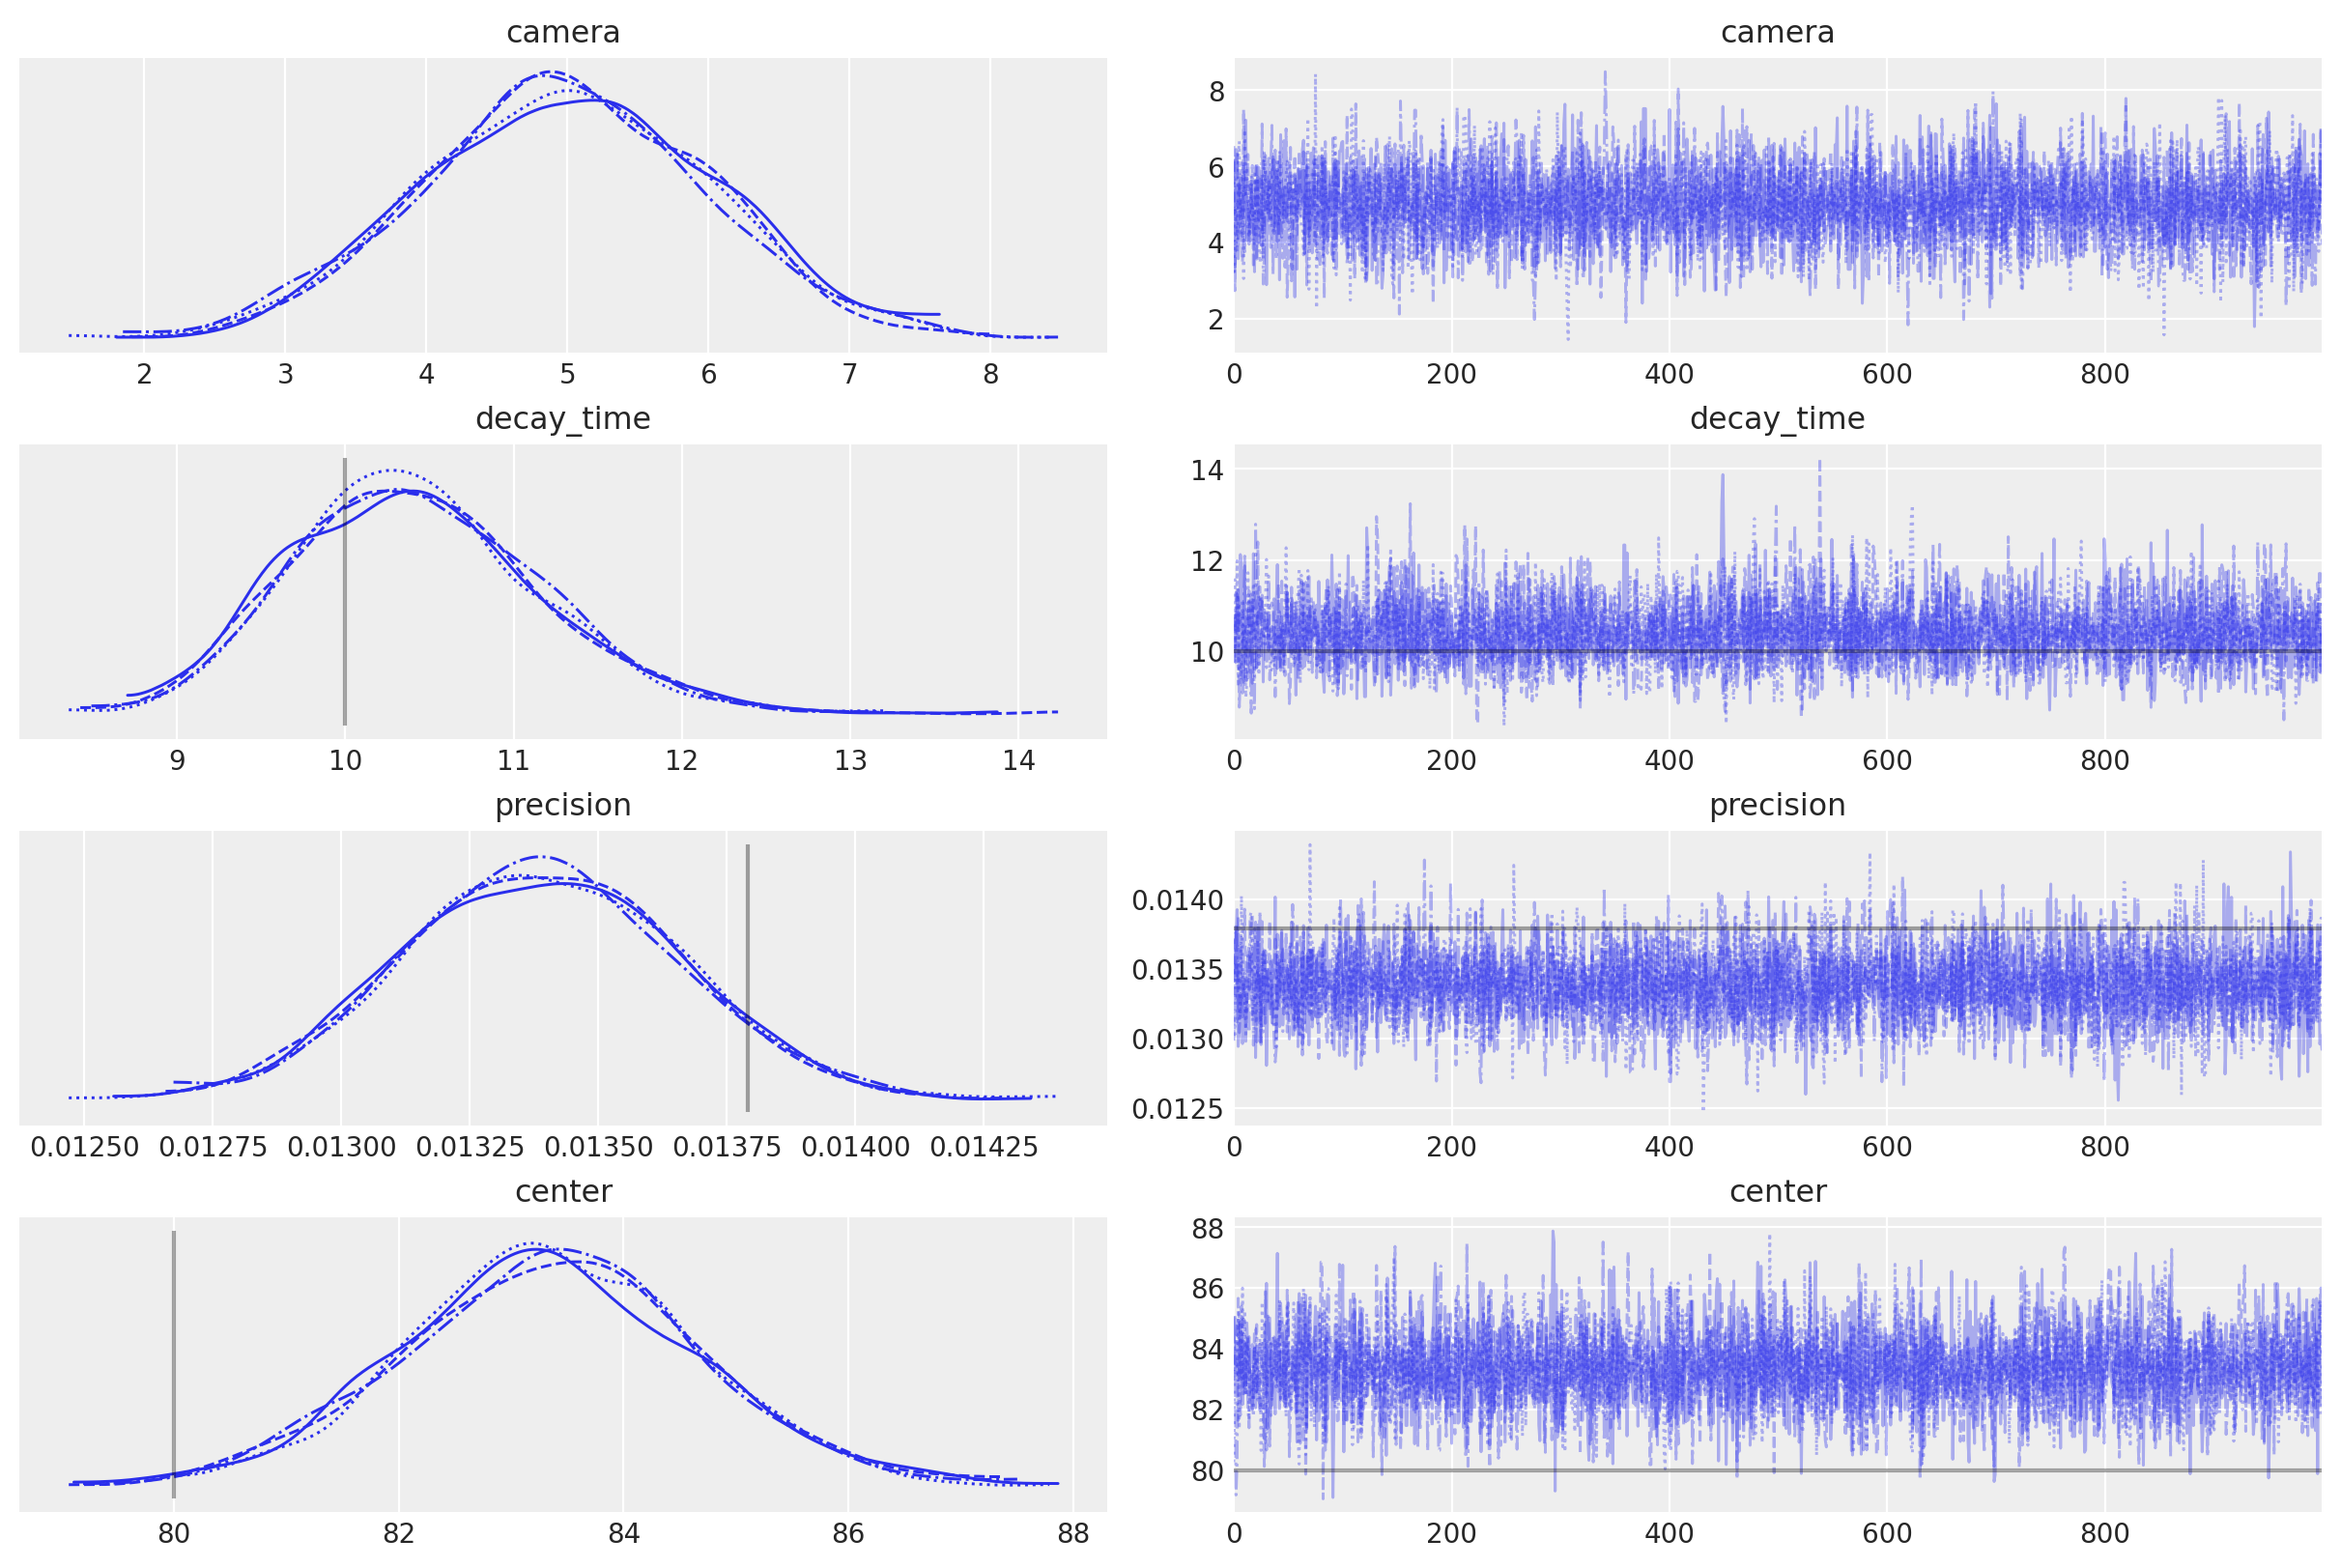

In [48]:
az.plot_trace(
    idata,
    lines=[
        ("decay_time", {}, tao),
        ("precision", {}, 1/(innovation_std**2)),
        ("center", {}, intensity_mean),
        ("noise_mean", {}, camera_noise_mean),
        ("noise_std", {}, camera_noise_std),
    ],
);